In [5]:
#1. module import
import numpy as np                         # 파이썬에서 쓰이는 또다른 자료형
# numpy 타입의 np 생성 np를 통해 접근한다. 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets       # torchvision 클래스에 있는 transforms, datasets 함수

In [6]:
# 이미지 전처리에 관련된 부분은 torchvision 에서 제공하는 transforms

In [7]:
import matplotlib.pyplot as plt      # 그리는 라이브러리

In [8]:
if torch.cuda.is_available():
     DEVICE=torch.device('cuda')
else:
     DEVICE=torch.device('cpu')

print('Using Pytorch version:',torch.__version__,'Device:',DEVICE)

Using Pytorch version: 1.11.0 Device: cuda


In [24]:
BATCH_SIZE=32        # MLP모델을 학습할 때 필요한 데이터 개수의 단위
EPOCHS=10
# 존재하는 Mini-batch를 전부 이용하는 횟수
# 하이퍼 파라미터를 지정할 때는 보통 대문자로 표기.
# 하이퍼 파라미터란 모델링할 때 사용자가 직접 세팅해주는 값

#  첫줄은 Mini-batch 1개 단위에 대해 데이터가 32개로 구성돼 있는 것을 의미.
#  위 예는 이제 32개의 데이터로 1회 학습을 하고
#  EPOCHS 수, 즉 10회독을 돌린다고 생각하면 된다.


In [10]:
# 3. MNIST 데이터 다운로드(Train ste, Test set 분리하기)
train_dataset = datasets.MNIST(root="../data/MNIST",
                                train = True, download=True,
                                transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root="../data/MNIST",
                                train = False,
                                transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset,
                                        batch_size = BATCH_SIZE,
                                        shuffle=True)

#  root : 데이터가 저장될 장소를 지정합니다. 여기서 '../'은 상위 폴더를 의미합니다.
#         이 예제에서는 코드가 실행되는 디렉터리의 상위 디렉터리에 존재하는 data 폴더 내 
#         MNIST폴더에 저장하는 내용입니다.
#  train : 대상 데이터가 MLP모델을 학습하기 위해 이용하는 학습 데이터인지
#          MLP모델의 학습된 이후 성능을 검증하기 위한 검증용 데이터인지를 지정합니다.
#  train = true 로 표기한 데이터는 학습용 데이터셋인 train_dataset 으로 설정.
#  train = false 로 표기한 데이터는 검증용 데이터셋인 test_dataset 으로 설정.
#  download : 해당 데이터를 인터넷에서 다운로드해 이용할 것인지를 지정.
#  transform : 데이터를 다운로드할 때, 이미지 데이터에 대한 기본적인 전처리를
#              동시에 진행할 수 있습니다. 여기서 torch모듈로 설계한 MLP의 Input으로 이용되기
#              때문에 'ToTensor()' 메서드를 이용해 'tensor'형태로 변경합니다. 
#  또한 한픽셀은 0~255 범위의 스칼라 값으로 구성돼있는데, 이를 0~1범위에서
#  정규화 과정이 진행됩니다. 데이터값이 커지면 불안정하거나 과적합되는 방향으로
#  학습이 진행될 우려가 있기 때문에 정규화 과정을 이용해 Input으로 이용하는 것을
#  권장합니다. 
#  shuffle : 데이터의 순서를 섞는다. 

In [11]:
# 4. 데이터 확인하기(1)
for(X_train,y_train)in train_loader:
    print('X_train:',X_train.size(),'type:',X_train.type())
    print('y_train:',y_train.size(),'type:',y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


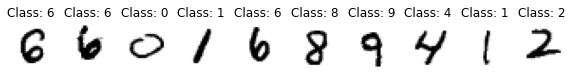

In [12]:
# 5. 데이터 확인하기(2)
pltsize=1
plt.figure(figsize=(10*pltsize,pltsize))
for i in range(10):
    plt.subplot(1,10,i+1)     # 여러 그래프 그리기, 첫숫자 : 행, 둘째 : 열
    plt.axis('off')           # 축없음
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28),cmap="gray_r")
    plt.title('Class: ' + str(y_train[i].item()))
    
    
    # imshow : 이미지 출력

In [25]:
# 6. MLP(Multi Layer Perceptron) 모델 설계하기
class Net(nn.Module):                 # nn.Module을 상속받는 Net클래스 생성
    def __init__(self):   
        # https://engineer-mole.tistory.com/190
        # https://wikidocs.net/89
        # 함수 기본구조
        # def 함수이름 (매개변수):
        # C#에 비유하면 self는 this, __init__은 생성자이다. 
        super(Net,self).__init__()
        # super : 상속받은 부모 클래스
        self.fc1=nn.Linear(28*28,512) # (input node수, output node수)
        self.fc2=nn.Linear(512,256)   # 이전 output node수 = 다음 input node수
        self.fc3=nn.Linear(256,10)
        self.dropout_prob = 0.5
        
    def forward(self,x): # MLP모델의 Forward Propagation을 정의
# 설계한 MLP 모델에 데이터를 입력했을 때
# output을 계산하기까지의 과정을 나열한 것.
        x=x.view(-1,28*28) # 8. 2차원 데이터를 1차원 데이터로 변환하기 위해
    # view메서드를 이용해 784크기의 1차원 데이터로 변환해 진행
    # https://wikidocs.net/52846
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc2(x)
        x = F.relu(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc3(x)
        x = F.log_softmax(x,dim=1)
        return x
    

In [20]:
#7.Optimizer, Object Function 설정하기
model=Net().to(DEVICE)                  # MLP모델을 기존에 선정한 'DEVICE'에 할당합니다. 
optimizer = torch.optim.SGD(model.parameters(),lr=0.01,momentum=0.5)
# Back Propagation을 이용해 파라미터를 업데이트할 때 이용하는 Optimizer를 정의합니다.
# SGD알고리즘을 이용하며 Learning Rate = 0.01, momentum=0.5로 설정
criterion=nn.CrossEntropyLoss()
# MLP모델의 output값과 계산될 Label값은 Class를 표현하는 원-핫 인코딩 값입니다.
# MLP모델의 output값과 원-핫 인코딩 값과의 Loss는 CrossEntropy를 이용해 계산하기 위해
# criterion은 nn.CrossEntropyLoss() 로 설정. 

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [21]:
#8. MLP모델 학습을 진행하며 "학습 데이터"에 대한 모델 성능을 확인하는 함수 정의(train_loader)
def train(model, train_loader,optimizer,log_interval):
    model.train()         # 학습상태로 지정
    for batch_idx,(image, label) in enumerate(train_loader):
        image=image.to(DEVICE)
        label=label.to(DEVICE)
        optimizer.zero_grad()
        output=model(image)
        loss=criterion(output,label)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval==0:
            print("Train Epoch: {}[{}/{}({:.0f}%)]\tTrain Loss: {:.6f}"
                  .format(Epoch,batch_idx * len(image),
                len(train_loader.dataset),100.*batch_idx/len(train_loader),loss.item()))

In [22]:
#9. 학습되는 과정속에서 "검증데이터"에 대한 모델 성능을 확인하는 함수 정의(test_loader)
def evaluate(model,test_loader):
    model.eval()                  # 평가상태로 지정
    test_loss=0
    correct=0
    
    with torch.no_grad():
        for image, label in test_loader:
            image=image.to(DEVICE)              # 8과 동일
            label=label.to(DEVICE)              # 8과 동일
            output=model(image)                 # 8과 동일
            test_loss+=criterion(output,label).item()
            prediction = output.max(1,keepdim = True)[1]
            # MLP 모델의 output값은 크기가 10인 벡터값입니다. 
            # 계산된 벡터값 내 가장 큰 값인 위치에 대해 해당 위치에 대응하는 클래스로 예측했다고 판단합니다.
            correct += prediction.eq(label.view_as(prediction)).sum().item()
            # MLP모델이 최종으로 예측한 클래스 값과 실제 레이블이 의미하는 클래스가 맞으면 correct에 더해 올바르게 예측한 횟수를 저장
                        
    test_loss /= len(test_loader.dataset)
    # 현재까지 계산된 test_loss 값을 test_loader내에 존재하는 Mini-Batch 개수(=10)만큼 나눠 평균 Loss값으로 계산.
    test_accuracy=100.*correct / len(test_loader.dataset)
    # test_loader 데이터중 얼마나 맞췄는지를 계산해 정확도를 계산합니다.
    return test_loss, test_accuracy

In [26]:
#10. MLP학습을 실행하면서 Train, Test set의 Loss및 Test set Accuracy를 확인하기
for Epoch in range(1,EPOCHS+1):
    train(model,train_loader,optimizer,log_interval = 200)
    test_loss, test_accuracy=evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %\n".
          format(Epoch,test_loss,test_accuracy))

Train Epoch: 1[0/60000(0%)]	Train Loss: 0.331665
Train Epoch: 1[6400/60000(11%)]	Train Loss: 0.680924
Train Epoch: 1[12800/60000(21%)]	Train Loss: 0.677785
Train Epoch: 1[19200/60000(32%)]	Train Loss: 0.640644
Train Epoch: 1[25600/60000(43%)]	Train Loss: 0.708244
Train Epoch: 1[32000/60000(53%)]	Train Loss: 0.654457
Train Epoch: 1[38400/60000(64%)]	Train Loss: 0.514370
Train Epoch: 1[44800/60000(75%)]	Train Loss: 0.458282
Train Epoch: 1[51200/60000(85%)]	Train Loss: 0.371968
Train Epoch: 1[57600/60000(96%)]	Train Loss: 0.428850

[EPOCH: 1], 	Test Loss: 0.0138, 	Test Accuracy: 86.95 %

Train Epoch: 2[0/60000(0%)]	Train Loss: 0.305586
Train Epoch: 2[6400/60000(11%)]	Train Loss: 0.476015
Train Epoch: 2[12800/60000(21%)]	Train Loss: 0.697986
Train Epoch: 2[19200/60000(32%)]	Train Loss: 0.436990
Train Epoch: 2[25600/60000(43%)]	Train Loss: 0.583620
Train Epoch: 2[32000/60000(53%)]	Train Loss: 0.749871
Train Epoch: 2[38400/60000(64%)]	Train Loss: 0.397912
Train Epoch: 2[44800/60000(75%)]	Tra